In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
import numpy as np
import pandas as pd
import tqdm
import glob
import os

pd.options.display.max_rows = 99
pd.options.display.max_columns = 60

from nba_api.stats.static import teams, players

import altair as alt
from altair_saver import save as alt_save

pd.set_option('max_columns', 120)
pd.set_option('max_rows', 50)

/home/noone/.virtualenvs/env36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_teams = pd.read_pickle('team_stats_20210317.pickle.zip')
print(df_teams.shape)
df_teams.head(2)

(30, 11)


,LEAGUE_ID,SEASON_ID,TEAM_ID,PTS_RANK,PTS_PG,REB_RANK,REB_PG,AST_RANK,AST_PG,OPP_PTS_RANK,OPP_PTS_PG
0,00,22020,1610612737,14,112.9,7,45.8,20,24.3,12,111.4
0,00,22020,1610612738,19,112.1,15,44.0,26,22.7,10,111.1


In [3]:
df_rost = pd.read_pickle('./rosters_20210317.pickle.zip')
print(df_rost.shape)
df_rost.head(2)

(493, 14)


,TeamID,SEASON,LeagueID,PLAYER,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID
0,1610612737,2020,00,Brandon Goodwin,brandon-goodwin,0,G,6-0,180,"OCT 02, 1995",25.0,2,Florida Gulf Coast,1629164
1,1610612737,2020,00,Nathan Knight,nathan-knight,1,F-C,6-10,253,"SEP 20, 1997",23.0,R,William & Mary,1630233


In [4]:
df_stats = pd.read_pickle('./all_players_seasons_stats_20210317.pickle.zip')
print(df_stats.shape)
df_stats.head(3)

(2893, 27)


,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1629164,2018-19,00,1610612743,DEN,23.0,16,0,57.0,6,23,0.261,2,6,0.333,9,11,0.818,1,2,3,14,0,0,3,7,23
1,1629164,2019-20,00,1610612737,ATL,24.0,34,1,430.0,76,190,0.400,26,87,0.299,28,30,0.933,11,61,72,51,12,4,29,43,206
2,1629164,2020-21,00,1610612737,ATL,25.0,26,0,294.0,36,108,0.333,15,53,0.283,17,24,0.708,3,24,27,43,10,0,14,23,104


In [5]:
def sum_season(gr, cols=['GP', 'MIN', 'REB', 'PTS', 'AST']):
    if len(gr) == 1:
        return pd.Series({c: gr[c].iloc[0] for c in cols})
    tot = gr[gr.TEAM_ABBREVIATION == 'TOT']
    return pd.Series({c: tot[c].iloc[0] for c in cols})

season_sums = df_stats.groupby(['PLAYER_ID', 'SEASON_ID']).apply(sum_season).reset_index()
print(season_sums.shape)
season_sums.head()

(2521, 7)


,PLAYER_ID,SEASON_ID,GP,MIN,REB,PTS,AST
0,2544,2003-04,79.0,3120.0,432.0,1654.0,465.0
1,2544,2004-05,80.0,3388.0,588.0,2175.0,577.0
2,2544,2005-06,79.0,3361.0,556.0,2478.0,521.0
3,2544,2006-07,78.0,3190.0,526.0,2132.0,470.0
4,2544,2007-08,75.0,3027.0,592.0,2250.0,539.0


,PLAYER_ID,SEASON_ID,GP,MIN,REB,PTS,AST,REB_per_game,PTS_per_game,AST_per_game
0,2544,2003-04,79.0,3120.0,432.0,1654.0,465.0,5.468354,20.936709,5.886076
1,2544,2004-05,80.0,3388.0,588.0,2175.0,577.0,7.350000,27.187500,7.212500


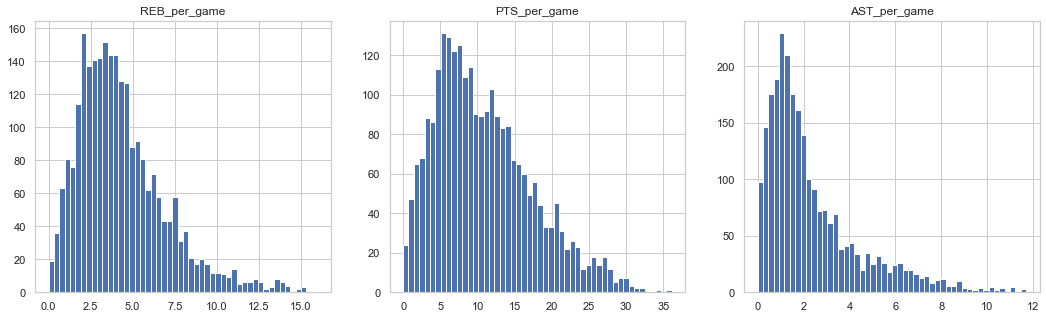

In [6]:
_cols = [ 'REB', 'PTS', 'AST']
ncols = len(_cols)
_, axes = plt.subplots(1, ncols, figsize=(ncols*6, 5))
for col, ax in zip(_cols, axes.flatten()):
    new_col = f'{col}_per_game'
    season_sums[new_col] = season_sums[col] / season_sums.GP
    season_sums[new_col].hist(bins=50, ax=ax)
    ax.set_title(new_col)
season_sums.head(2)

In [7]:
pls = pd.DataFrame(players.get_active_players())
pls.head()

,id,full_name,first_name,last_name,is_active
0,203500,Steven Adams,Steven,Adams,True
1,1628389,Bam Adebayo,Bam,Adebayo,True
2,200746,LaMarcus Aldridge,LaMarcus,Aldridge,True
3,1629734,Kyle Alexander,Kyle,Alexander,True
4,1629638,Nickeil Alexander-Walker,Nickeil,Alexander-Walker,True


In [8]:
pls[pls.first_name == 'Blake']

,id,full_name,first_name,last_name,is_active
187,201933,Blake Griffin,Blake,Griffin,True


In [9]:
season_sums[season_sums.PLAYER_ID == 201933].sort_values('PTS_per_game')

,PLAYER_ID,SEASON_ID,GP,MIN,REB,PTS,AST,REB_per_game,PTS_per_game,AST_per_game
531,201933,2020-21,20.0,626.0,104.0,245.0,77.0,5.200000,12.250000,3.850000
530,201933,2019-20,18.0,512.0,84.0,279.0,59.0,4.666667,15.500000,3.277778
523,201933,2012-13,80.0,2598.0,662.0,1440.0,299.0,8.275000,18.000000,3.737500
522,201933,2011-12,66.0,2392.0,717.0,1368.0,210.0,10.863636,20.727273,3.181818
526,201933,2015-16,35.0,1170.0,294.0,749.0,170.0,8.400000,21.400000,4.857143
528,201933,2017-18,58.0,1970.0,428.0,1242.0,334.0,7.379310,21.413793,5.758621
527,201933,2016-17,61.0,2076.0,497.0,1316.0,300.0,8.147541,21.573770,4.918033
525,201933,2014-15,67.0,2356.0,508.0,1469.0,354.0,7.582090,21.925373,5.283582
521,201933,2010-11,82.0,3112.0,989.0,1845.0,312.0,12.060976,22.500000,3.804878
524,201933,2013-14,80.0,2863.0,757.0,1930.0,309.0,9.462500,24.125000,3.862500


(490, 13)


,PLAYER_ID,SEASON_ID_REB,GP_REB,MIN_REB,REB_per_game,SEASON_ID_PTS,GP_PTS,MIN_PTS,PTS_per_game,SEASON_ID_AST,GP_AST,MIN_AST,AST_per_game
0,2544,2017-18,82.0,3026.0,8.646341,2005-06,79.0,3361.0,31.367089,2019-20,67.0,2316.0,10.208955
1,2546,2013-14,77.0,2982.0,8.077922,2006-07,65.0,2486.0,28.938462,2015-16,72.0,2530.0,4.152778
2,2617,2004-05,80.0,2675.0,9.075000,2007-08,49.0,1805.0,12.020408,2007-08,49.0,1805.0,1.387755
3,2730,2011-12,54.0,2070.0,14.537037,2010-11,78.0,2935.0,22.871795,2006-07,82.0,3023.0,1.926829
4,2738,2009-10,82.0,3193.0,6.451220,2007-08,82.0,3242.0,19.878049,2010-11,67.0,2469.0,6.298507


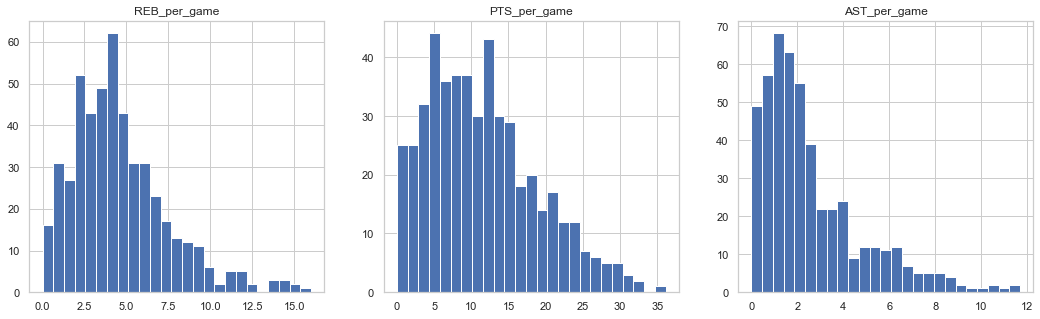

In [10]:
_bests = []
ncols = len(_cols)
_, axes = plt.subplots(1, ncols, figsize=(ncols*6, 5))
for col, ax in zip(_cols, axes.flatten()):
    new_col = f'{col}_per_game'
    _best = (season_sums
                    [['PLAYER_ID', 'SEASON_ID', 'GP', 'MIN', new_col]]
                    .rename(columns={c: f'{c}_{col}' for c in ['SEASON_ID', 'GP', 'MIN']})
                .sort_values(new_col, ascending=False)
                .drop_duplicates(['PLAYER_ID'], keep='first', ignore_index=True)
                .sort_values('PLAYER_ID')
                    .set_index('PLAYER_ID')
               )
    _bests.append(_best)
    _best[new_col].hist(bins=25, ax=ax)
    ax.set_title(new_col)
best_seasons = pd.concat(_bests, axis=1).reset_index()
print(best_seasons.shape)
best_seasons.head()

In [11]:
new_cols = [f'{col}_per_game' for col in _cols]
new_cols

['REB_per_game', 'PTS_per_game', 'AST_per_game']

In [12]:
df_rost_2 = pd.merge(df_rost, best_seasons, how='left', on='PLAYER_ID')
for c in (
#     ['GP', 'MIN', 'REB', 'PTS', 'AST'] + 
    new_cols
):
    df_rost_2[c].fillna(0, inplace=True)
df_rost_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493 entries, 0 to 492
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TeamID         493 non-null    int64  
 1   SEASON         493 non-null    object 
 2   LeagueID       493 non-null    object 
 3   PLAYER         493 non-null    object 
 4   PLAYER_SLUG    493 non-null    object 
 5   NUM            493 non-null    object 
 6   POSITION       493 non-null    object 
 7   HEIGHT         493 non-null    object 
 8   WEIGHT         493 non-null    object 
 9   BIRTH_DATE     493 non-null    object 
 10  AGE            493 non-null    float64
 11  EXP            493 non-null    object 
 12  SCHOOL         488 non-null    object 
 13  PLAYER_ID      493 non-null    int64  
 14  SEASON_ID_REB  490 non-null    object 
 15  GP_REB         490 non-null    float64
 16  MIN_REB        490 non-null    float64
 17  REB_per_game   493 non-null    float64
 18  SEASON_ID_

In [13]:
df = pd.merge(pd.DataFrame(teams.get_teams()), 
              pd.merge(df_teams, df_rost_2.groupby('TeamID')[new_cols].sum().reset_index(),
                       left_on='TEAM_ID', right_on='TeamID'),
              left_on='id', right_on='TeamID')

print(df.shape)
df.head()

(30, 22)


,id,full_name,abbreviation,nickname,city,state,year_founded,LEAGUE_ID,SEASON_ID,TEAM_ID,PTS_RANK,PTS_PG,REB_RANK,REB_PG,AST_RANK,AST_PG,OPP_PTS_RANK,OPP_PTS_PG,TeamID,REB_per_game,PTS_per_game,AST_per_game
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,00,22020,1610612737,14,112.9,7,45.8,20,24.3,12,111.4,1610612737,80.210564,209.745065,53.053231
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946,00,22020,1610612738,19,112.1,15,44.0,26,22.7,10,111.1,1610612738,67.543948,174.724621,42.368999
2,1610612739,Cleveland Cavaliers,CLE,Cavaliers,Cleveland,Ohio,1970,00,22020,1610612739,30,103.3,21,43.2,23,23.2,16,111.9,1610612739,93.443696,197.507914,43.448810
3,1610612740,New Orleans Pelicans,NOP,Pelicans,New Orleans,Louisiana,2002,00,22020,1610612740,4,115.9,4,46.6,9,26.3,27,115.7,1610612740,66.390672,173.743753,40.018036
4,1610612741,Chicago Bulls,CHI,Bulls,Chicago,Illinois,1966,00,22020,1610612741,11,114.4,10,44.6,8,26.3,24,114.3,1610612741,80.847075,187.120131,40.290652


# pts reb ast

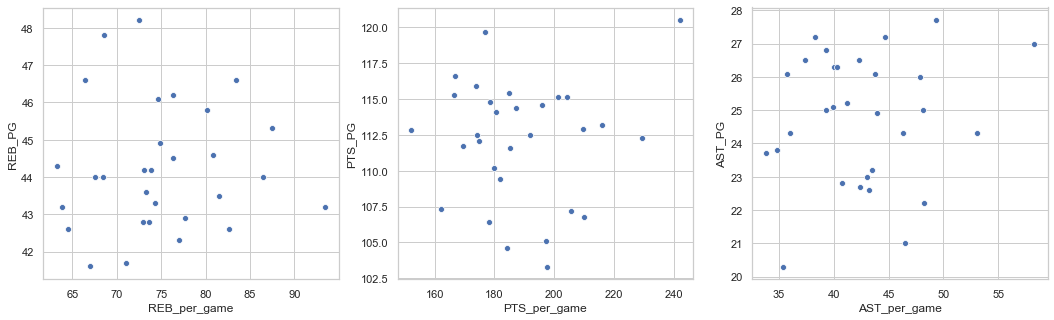

In [14]:
ncols = len(_cols)
_, axes = plt.subplots(1, ncols, figsize=(ncols*6, 5))
for col, ax in zip(_cols, axes.flatten()):
    new_col = f'{col}_per_game'
    sns.scatterplot(data=df, x=new_col, y=f'{col}_PG', ax=ax)

In [15]:
def plot(df, xcol, ycol, xcol_name, ycol_name):
    tt = alt.Chart(data=df, height=400, width=600)
    points = (tt.mark_point(color='blue')
             .encode(x=alt.X(xcol, title=xcol_name, scale=alt.Scale(zero=False)),
                     y=alt.Y(ycol, title=ycol_name, scale=alt.Scale(zero=False)))
            )

    text = points.mark_text(
        angle=315,
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='abbreviation'
    )


    return (
            (points 
             + text
            )
            .configure_legend(labelFontSize=15)
            .configure_axis(
                labelFontSize=15,
                titleFontSize=15
            )
        )

plot(df, xcol='PTS_per_game', ycol='PTS_PG', xcol_name='Наивная сумма очков', ycol_name='Среднее количество очков в сезоне 2020-21')

alt.LayerChart(...)

In [16]:
plot(df, xcol='REB_per_game', ycol='REB_PG', xcol_name='Наивная сумма подборов', ycol_name='Среднее количество подборов в сезоне 2020-21')

alt.LayerChart(...)

In [17]:
plot(df, xcol='AST_per_game', ycol='AST_PG', xcol_name='Наивная сумма передач', ycol_name='Среднее количество передач в сезоне 2020-21')

alt.LayerChart(...)

# price demand

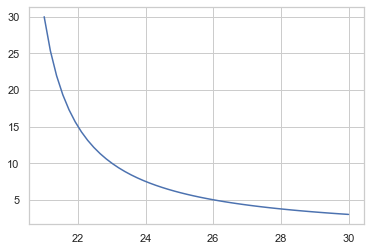

In [18]:
xs = np.linspace(1, 10, num=50) + 20
def usual(x):
    return 30 / (x - 20)
ys = [usual(x) for x in xs]
plt.plot(xs, ys)

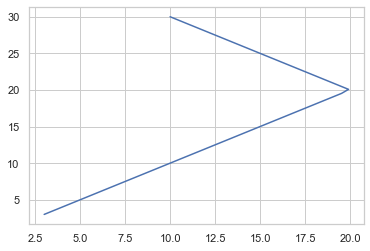

In [19]:
ys = np.linspace(3, 30, num=50)
def giff(y):
    return y if y < 20 else (40 - y)
xs = [giff(y) for y in ys]
plt.plot(xs, ys)